In [40]:
import sframe as sf
import numpy as np # note this allows us to refer to numpy as np instead 
import pandas as pd
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor #use RandomForestRegressor for regression problem
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 20

In [2]:
sales = sf.SFrame('kc_house_data.gl/')
# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to int, before using it below
sales['floors'] = sales['floors'].astype(int)

In [3]:
sales.show

<bound method SFrame.show of Columns:
	id	str
	date	datetime
	price	float
	bedrooms	float
	bathrooms	float
	sqft_living	float
	sqft_lot	int
	floors	int
	waterfront	int
	view	int
	condition	int
	grade	int
	sqft_above	int
	sqft_basement	int
	yr_built	int
	yr_renovated	int
	zipcode	str
	lat	float
	long	float
	sqft_living15	float
	sqft_lot15	float

Rows: 21613

Data:
+------------+---------------------------+-----------+----------+-----------+
|     id     |            date           |   price   | bedrooms | bathrooms |
+------------+---------------------------+-----------+----------+-----------+
| 7129300520 | 2014-10-13 00:00:00+00:00 |  221900.0 |   3.0    |    1.0    |
| 6414100192 | 2014-12-09 00:00:00+00:00 |  538000.0 |   3.0    |    2.25   |
| 5631500400 | 2015-02-25 00:00:00+00:00 |  180000.0 |   2.0    |    1.0    |
| 2487200875 | 2014-12-09 00:00:00+00:00 |  604000.0 |   4.0    |    3.0    |
| 1954400510 | 2015-02-18 00:00:00+00:00 |  510000.0 |   3.0    |    2.0    |
| 72375503

In [4]:
# Lets do some feature engineering.  In general it is expected that the home price will decline
# in value as the house ages.  So we will create a new feature called 'age' from the 'yr_built'
# feature
from datetime import datetime
sales['age'] = datetime.now().year - sales['yr_built']

              price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04   
mean   5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04   
std    3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       1.446213      0.007542      0.234303      3.409430      7.656873   
std        0.551894      0.086517      0.766318    

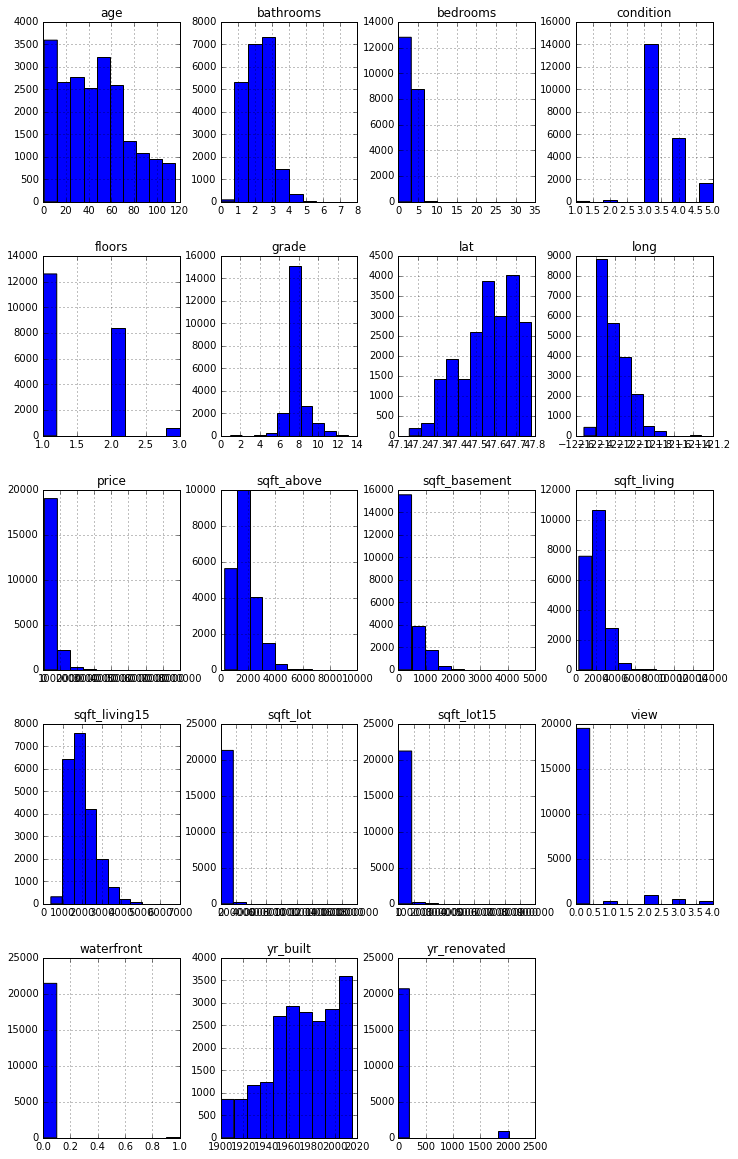

In [5]:
house_data_pandas = sales.to_dataframe()
print(house_data_pandas.describe())
house_data_pandas.hist();

Things to Note from the Data
1. The middle 50% of the price ranges from $322k to $645k.  It is better to slice this data into low price zone, middle price zone and high price zones and then have three separate linear regression equation for each zone.  Another way would be to cluster this data into 3 or more clusters using price as a cluster parameter.  With only 21,613 homes in the data (which is kind of small), we are not going to slice the data in this example but are going to fit a linear regression equation on the whole data.  There are some clustering examples that are shown on the website.
2. Most of the data doesn't have waterfront or view data or year renovated.  These variables will be ignored in the linear regression.  
3. A new variable called 'age' will derived from the yr_built variable.  


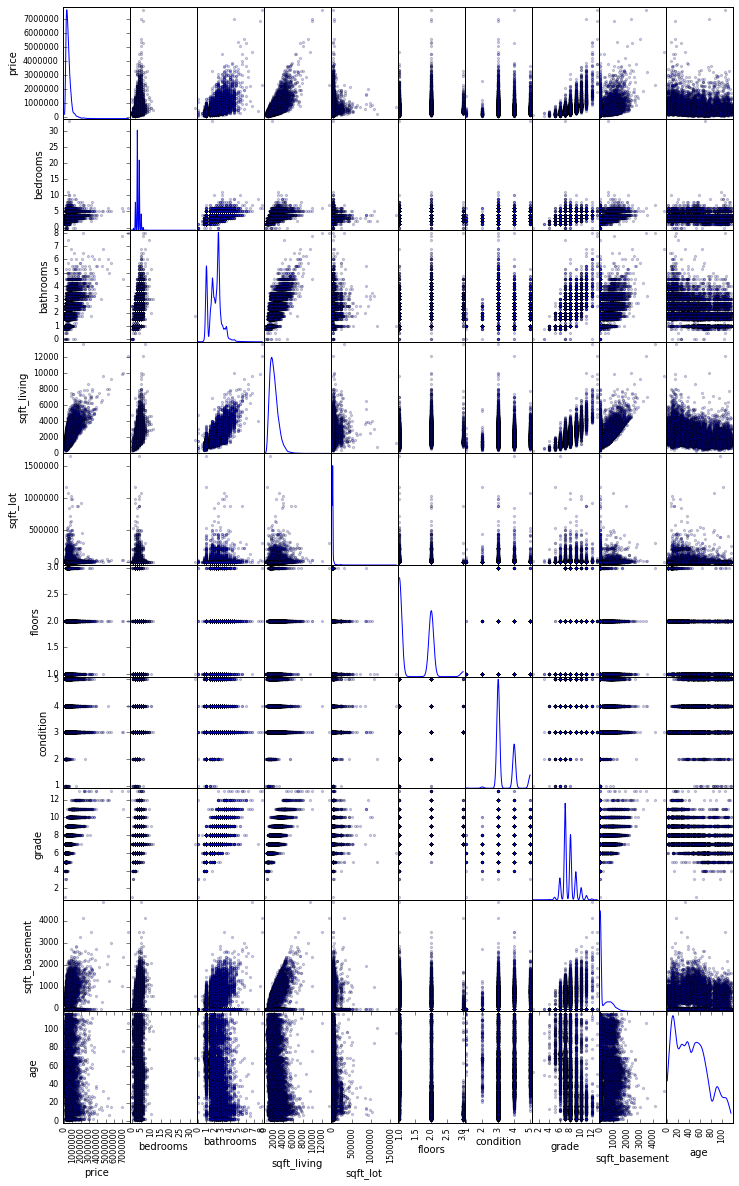

In [6]:
# plotting the various features against the other features.
less_features = ['price',
                'bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'condition', 
                'grade',
                'sqft_basement',
                'age',            
                ]
house_data_pandas_lessfeatures = house_data_pandas[less_features]
from pandas.tools.plotting import scatter_matrix
scatter_matrix(house_data_pandas_lessfeatures, alpha=0.2, diagonal='kde');

Things to note on the cross dimensional plots
1. There doesn't seem to be any obvious correlation of the price to any of the variables except for the bedrooms and the square feet.  
2. A separate plot will be shown for the price vs zipcode - it doesn't show any obvious correlation either.  The price is seen to vary from the low to the high prices for all the zipcodes.  
3. Price seems to be affected by construction quality grade.  see here for more info on the grade numbers - http://www.zillow.com/advice-thread/What-exactly-does-construction-quality-mean-what-rating-would-you-accept-if-choosing-a-house/360323/ 

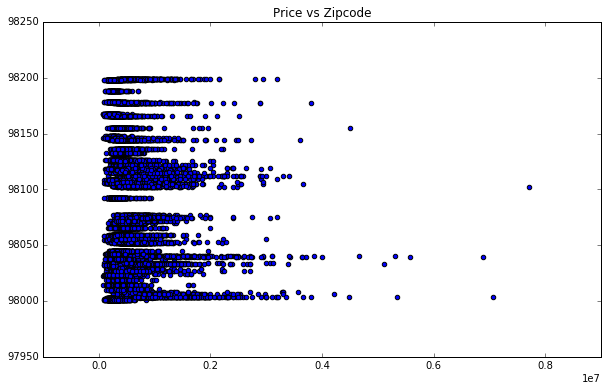

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(sales['price'], sales['zipcode'])
plt.title("Price vs Zipcode")
plt.show()

In [31]:
# Let's try some Clustering of the data.  The price range on this data goes from
# $75k to $7.7 mil - a big range.  We know the home price ranges vary by square feet.  We will try to
# cluster this data based on price, and sq feet.  Maybe start with 3 clusters initially.

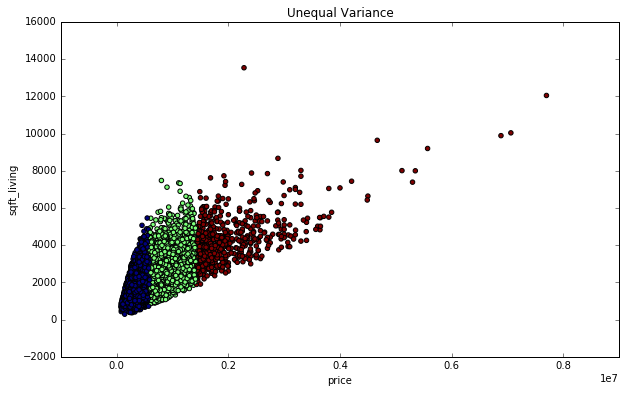

In [9]:
from sklearn.cluster import KMeans
random_state = 170
X_cluster = sales['price','sqft_living'].to_numpy()
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_cluster)

plt.figure(figsize=(10,6))
plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=y_pred)
plt.title("Unequal Variance")
plt.ylabel('sqft_living')
plt.xlabel('price')
plt.show()

We are not going to cluster in this example.  The Clustering seems to be partitioning data by the different price ranges, the square feet seems to be common across all the three clusters.  

In [10]:
sales_lowprice = sales[sales['price']<322000.0]
sales_medprice = sales[(sales['price']>= 320000.0) & (sales['price']< 645000.0)]
sales_highprice = sales[sales['price']>=645000.0]
print "num rows for low price",sales_lowprice.num_rows()
print "num rows for medium price",sales_medprice.num_rows()
print "num rows for high price",sales_highprice.num_rows()

num rows for low price 5404
num rows for medium price 10921
num rows for high price 5413


In [11]:
def get_numpy_data(data_sframe, features, output):
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe 
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [12]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    features = feature_matrix / norms
    return (features,norms)

In [13]:
train_data,test_data = sales.random_split(.8,seed=0)

In [22]:
all_features = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'waterfront', # waterfront property
                'view', # type of view
                'condition', # condition of house
                'grade', # measure of quality of construction
                'lat', 'long', # the lat-long of the parcel
                'sqft_above', # square feet above ground
                'sqft_basement', # square feet in basement
                'sqft_living15', # average sq.ft. of 15 nearest neighbors
                'sqft_lot15', # average lot size of 15 nearest neighbors 
                'age']

In [23]:
(all_feature_matrix, all_output) = get_numpy_data(train_data,all_features, 'price')
(test_feature_matrix, test_output) = get_numpy_data(test_data, all_features, 'price')
#(normalized_all_feature_matrix, all_norms) = normalize_features(all_feature_matrix) # normalize features

In [24]:
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create Random Forest object
model= RandomForestRegressor(n_estimators=1000)
# Train the model using the training sets and check score
model.fit(all_feature_matrix, all_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

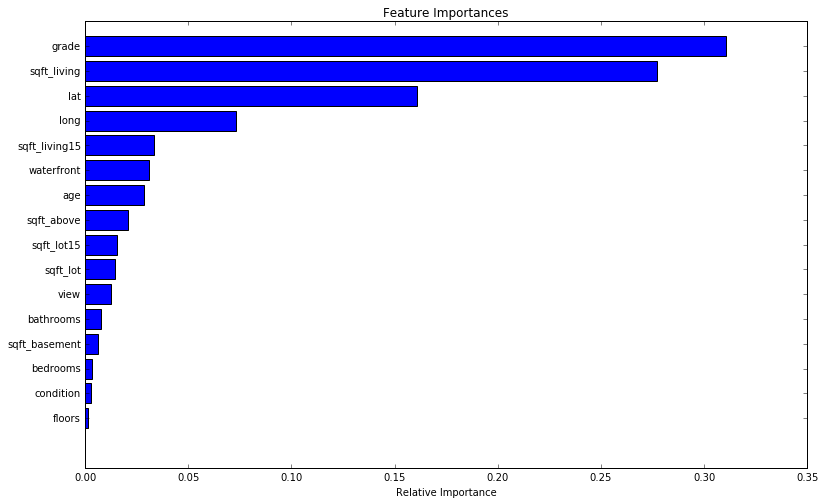

In [25]:
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8 * 1.618, 8))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.asarray(all_features)[indices])
plt.xlabel('Relative Importance')

In [34]:
lassoreg_all = Lasso(alpha=10,normalize=True, max_iter=1e5)
lassoreg_all.fit(all_feature_matrix,all_output)
y_pred = lassoreg_all.predict(test_feature_matrix)
print "R2 ", lassoreg_all.score(test_feature_matrix, test_output)
print "Coefficients", lassoreg_all.coef_
print "Intercept", lassoreg_all.intercept_

R2  0.685013871546
Coefficients [ -3.43735163e+04   4.11301695e+04   1.52159252e+02   4.12508369e-02
  -0.00000000e+00   6.08088180e+05   4.65366788e+04   2.55662482e+04
   1.01236734e+05   5.52094292e+05  -1.01297425e+05   2.70794724e+01
   0.00000000e+00   2.29884334e+01  -2.17433913e-01   2.57239083e+03]
Intercept -39470508.0204


In [35]:
# follow the usual sklearn pattern: import, instantiate, fit
lm = LinearRegression(normalize=True)
lm.fit(all_feature_matrix, all_output)
# calculate the R-squared
print "R2",lm.score(all_feature_matrix, all_output)
# print intercept and coefficients
print "Coefficients", lm.coef_
print "Intercept", lm.intercept_

R2 0.697127291569
Coefficients [ -3.84869298e+04   4.56637244e+04   8.89743173e+01   1.56045440e-01
  -2.18931718e+03   6.17905111e+05   4.64982019e+04   2.75126361e+04
   1.01044615e+05   5.57858804e+05  -1.11079733e+05   9.27353145e+01
   6.14406364e+01   2.48872543e+01  -4.02641142e-01   2.63382588e+03]
Intercept -40947788.6636


In [43]:
def lasso_regression(feature_data, output_data, test_feature_data, test_output_data,
                     alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5, fit_intercept=True)
    lassoreg.fit(feature_data,output_data)
    y_pred = lassoreg.predict(feature_data)
        
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(output_data/1000,y_pred/1000,'.')
        plt.plot(output_data/1000,output_data/1000)
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-output_data)**2)
    rmse = math.sqrt(rss/len(y_pred))
    ret = [rss]
    ret.extend([rmse])
    ret.extend([lassoreg.score(test_feature_data, test_output_data)])
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

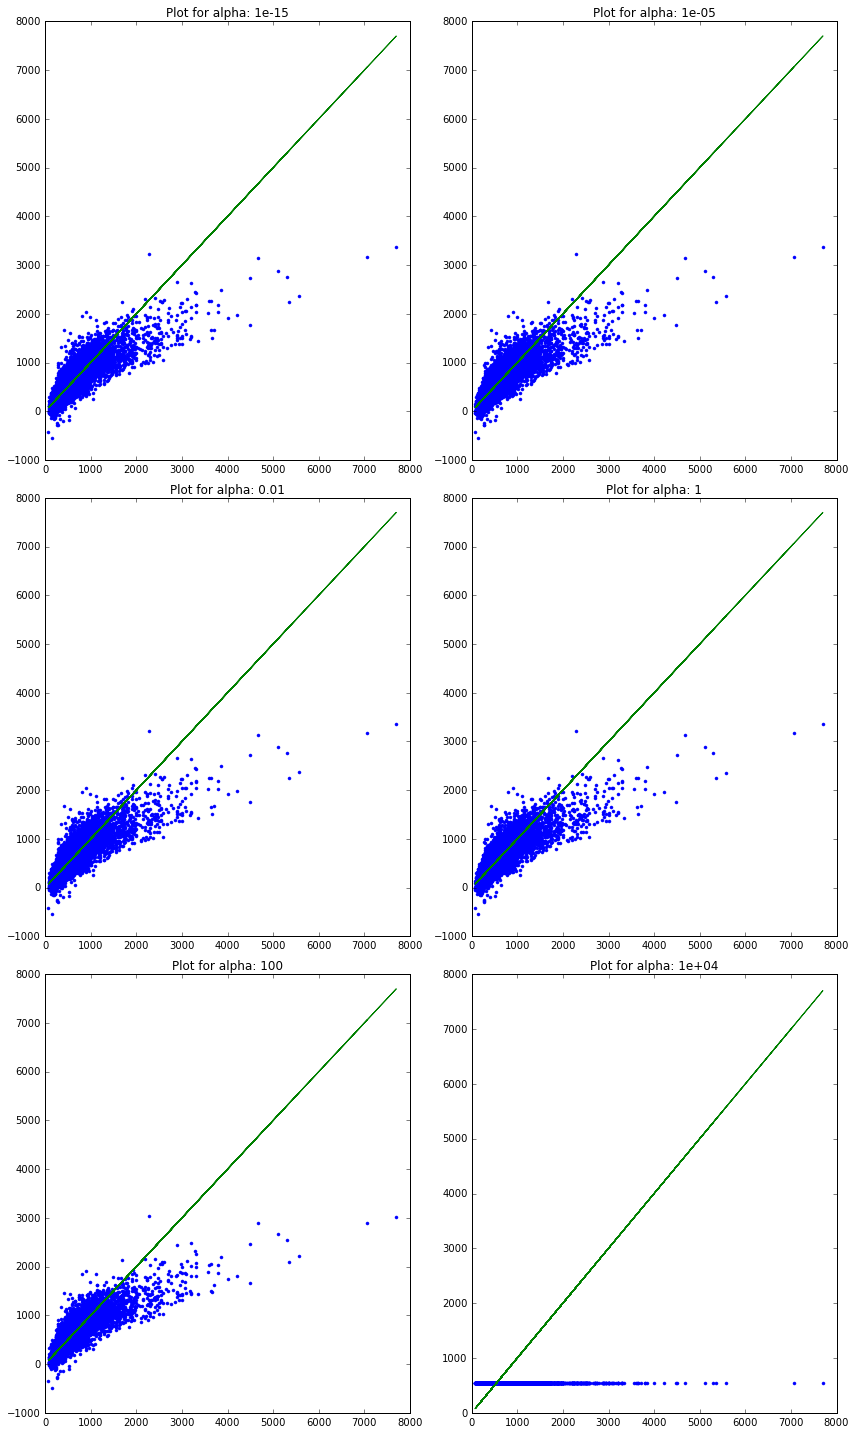

In [44]:
#Define the alpha values to test
alpha_lasso = [1e-15, 1e-5,1e-2, 1, 10, 100, 1000, 10000]

#Initialize the dataframe to store coefficients
col = ['rss','rmse','R2','intercept'] + all_features
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,8)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-15:321, 1e-5:322,1e-2:323, 1:324, 100:325, 10000:326}
#Iterate over the 8 alpha values:
for i in range(8):
    coef_matrix_lasso.iloc[i,] = lasso_regression(all_feature_matrix, 
                    all_output, test_feature_matrix, test_output, alpha_lasso[i], models_to_plot)

In [45]:
coef_matrix_lasso

,rss,rmse,R2,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,lat,long,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age
alpha_1e-15,7.19553e+14,203450,0.684149,-4.09478e+07,-38486.9,45663.7,287.461,0.156045,-2189.32,617905,46498.2,27512.6,101045,557859,-111080,-105.751,-137.046,24.8873,-0.402641,2633.83
alpha_1e-05,7.19553e+14,203450,0.684149,-4.09478e+07,-38486.9,45663.7,287.127,0.156045,-2189.31,617905,46498.2,27512.6,101045,557859,-111080,-105.417,-136.712,24.8872,-0.402641,2633.83
alpha_0.01,7.19553e+14,203450,0.68415,-4.09459e+07,-38482.6,45657.9,150.418,0.155932,-2182.09,617895,46498.1,27510.9,101045,557852,-111067,31.288,0,24.8857,-0.402452,2633.8
alpha_1,7.19561e+14,203451,0.684278,-4.07636e+07,-38056,45079.2,150.766,0.144699,-1467.27,616916,46492.3,27342,101049,557129,-109857,30.6291,0,24.7362,-0.383766,2630.83
alpha_10,7.20152e+14,203534,0.685014,-3.94705e+07,-34373.5,41130.2,152.159,0.0412508,-0,608088,46536.7,25566.2,101237,552094,-101297,27.0795,0,22.9884,-0.217434,2572.39
alpha_1e+02,7.55243e+14,208434,0.675034,-2.78106e+07,-0,4636.57,160.753,0,0,525501,46531,8358.67,102495,507904,-23921,0,0,7.68126,-0,1858.8
alpha_1e+03,1.44607e+15,288416,0.396912,50345.1,0,0,104.671,0,0,0,0,0,35441,0,-0,0,0,0,0,0
alpha_1e+04,2.37576e+15,369681,-0.000107058,539367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0


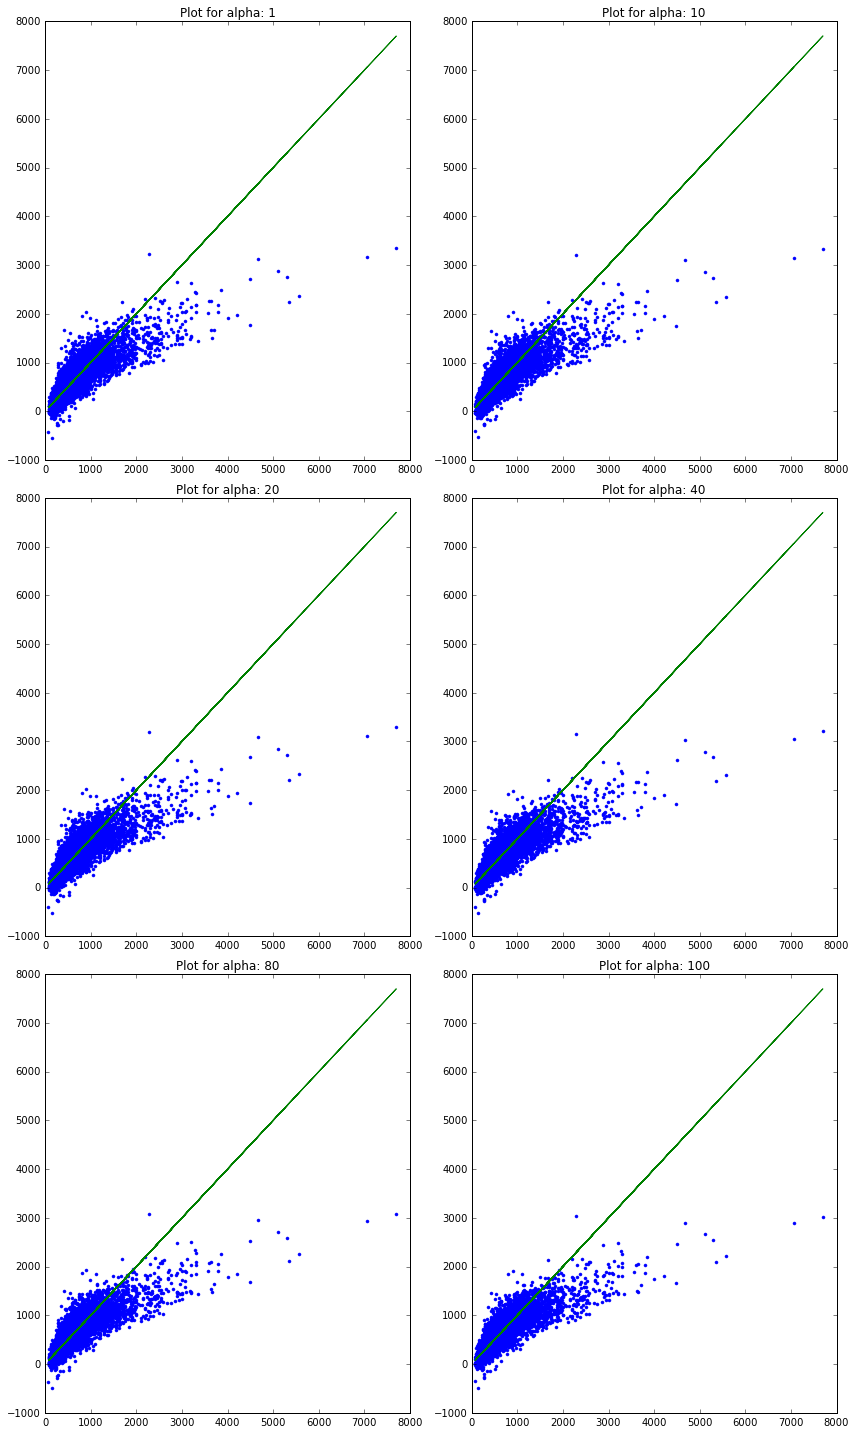

In [46]:
# We want to choose an alpha between 10 and 100 - alpha 100 drops a few of features.
#We are going to test a series of alpha between 1 and 100
alpha_lasso_refine = [1, 10, 20, 40, 50, 60, 80, 100]

#Initialize the dataframe to store coefficients
col = ['rss','rmse','R2','intercept'] + all_features
ind = ['alpha_%.2g'%alpha_lasso_refine[i] for i in range(0,8)]
coef_matrix_lasso_refine = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
#models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}
models_to_plot = {1:321, 10:322,20:323, 40:324, 80:325, 100:326}
#Iterate over the 8 alpha values:
for i in range(8):
    coef_matrix_lasso_refine.iloc[i,] = lasso_regression(all_feature_matrix, 
             all_output, test_feature_matrix, test_output, alpha_lasso_refine[i], models_to_plot)

In [47]:
coef_matrix_lasso_refine

,rss,R2,rmse,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,lat,long,sqft_above,sqft_basement,sqft_living15,sqft_lot15,age
alpha_1,7.19561e+14,203451,0.684278,-4.07636e+07,-38056,45079.2,150.766,0.144699,-1467.27,616916,46492.3,27342,101049,557129,-109857,30.6291,0,24.7362,-0.383766,2630.83
alpha_10,7.20152e+14,203534,0.685014,-3.94705e+07,-34373.5,41130.2,152.159,0.0412508,-0,608088,46536.7,25566.2,101237,552094,-101297,27.0795,0,22.9884,-0.217434,2572.39
alpha_20,7.21512e+14,203726,0.685243,-3.83083e+07,-30298.6,37143.5,153.104,0,0,598891,46506.6,23561.1,101479,547468,-93673.1,23.6812,0,21.1437,-0.113928,2492.62
alpha_40,7.26312e+14,204403,0.684468,-3.61566e+07,-22054.4,29099.6,154.738,-0,0,581108,46354.1,19639,101945,538774,-79620.5,16.8406,0,17.7473,-0,2327.8
alpha_50,7.29568e+14,204860,0.683712,-3.47314e+07,-18120.3,24925.9,155.914,-0,0,572067,46358.5,17704.4,102134,533567,-70075.6,13.511,0,16.1258,-0,2248.3
alpha_60,7.33549e+14,205419,0.682581,-3.3304e+07,-14188.2,20743.4,157.106,-0,0,563028,46362.2,15768.4,102328,528356,-60514.4,10.1715,0,14.4967,-0,2168.79
alpha_80,7.43686e+14,206833,0.679203,-3.04566e+07,-6304.73,12373.1,159.407,-0,0,544941,46377.4,11907.3,102716,517963,-41440.7,3.56366,0,11.2535,-0,2009.71
alpha_1e+02,7.55243e+14,208434,0.675034,-2.78106e+07,-0,4636.57,160.753,0,0,525501,46531,8358.67,102495,507904,-23921,0,0,7.68126,-0,1858.8


In [68]:
# I am just playing around here using a smaller set of features
sub_features = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'waterfront', # waterfront property
                'condition', # condition of house
                'grade', # measure of quality of construction
                'sqft_above', # square feet above ground
                'age']
(sub_feature_matrix, sub_output) = get_numpy_data(train_data,sub_features, 'price')
(test_sub_feature_matrix, test_sub_output) = get_numpy_data(test_data,sub_features, 'price')

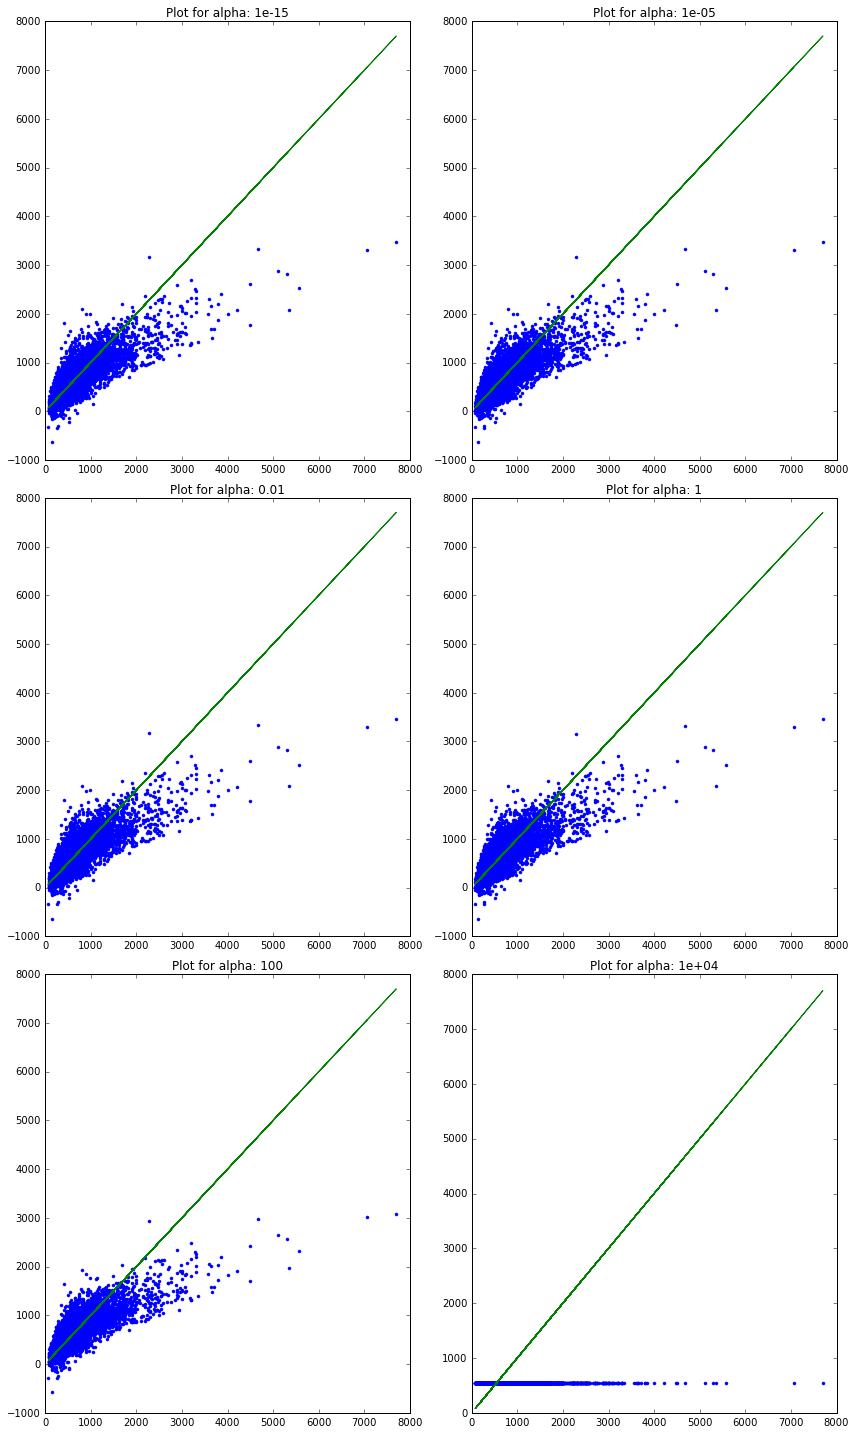

In [69]:
#Define the alpha values to test
alpha_lasso_sub = [1e-15, 1e-5,1e-2, 1, 10, 100, 1000, 10000]

#Initialize the dataframe to store coefficients
col = ['rss','rmse','R2','intercept'] + sub_features
ind = ['alpha_%.2g'%alpha_lasso_sub[i] for i in range(0,8)]
coef_matrix_lasso_sub = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
#models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}
models_to_plot = {1e-15:321, 1e-5:322,1e-2:323, 1:324, 100:325, 10000:326}
#Iterate over the 8 alpha values:
for i in range(8):
    coef_matrix_lasso_sub.iloc[i,] = lasso_regression(sub_feature_matrix,sub_output,
                                         test_sub_feature_matrix,test_sub_output,alpha_lasso_sub[i], models_to_plot)

In [70]:
coef_matrix_lasso_sub
# Obviously the R2 goes down from 0.68 to 0.63.  We are going to keep the bigger model with alpha = 20.

,rss,rmse,R2,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,age
alpha_1e-15,8.32489e+14,218834,0.627295,-1.05924e+06,-46274.9,48872.5,191.737,-0.19996,23882.7,731714,16516.9,132320,-16.0993,3896.46
alpha_1e-05,8.32489e+14,218834,0.627295,-1.05924e+06,-46274.9,48872.5,191.737,-0.199959,23882.7,731714,16516.8,132320,-16.0992,3896.46
alpha_0.01,8.32489e+14,218834,0.627296,-1.05922e+06,-46271.1,48872.2,191.722,-0.199936,23873.1,731707,16515.6,132318,-16.0817,3896.37
alpha_1,8.32499e+14,218835,0.627413,-1.05712e+06,-45890.8,48801.8,190.299,-0.197588,22932.5,731036,16395.4,132163,-14.3715,3887.31
alpha_10,8.33409e+14,218955,0.628069,-1.03812e+06,-42454.3,48141.3,178.18,-0.175287,14740.1,724784,15250.5,130797,-0,3803.79
alpha_1e+02,8.66463e+14,223254,0.621245,-904772,-6180.89,15021.6,162.904,-0,0,644818,168.85,125429,0,2869.18
alpha_1e+03,1.44607e+15,288416,0.396912,50345.1,0,0,104.671,0,0,0,0,35441,0,0
alpha_1e+04,2.37576e+15,369681,-0.000107058,539367,0,0,0,0,0,0,0,0,0,-0


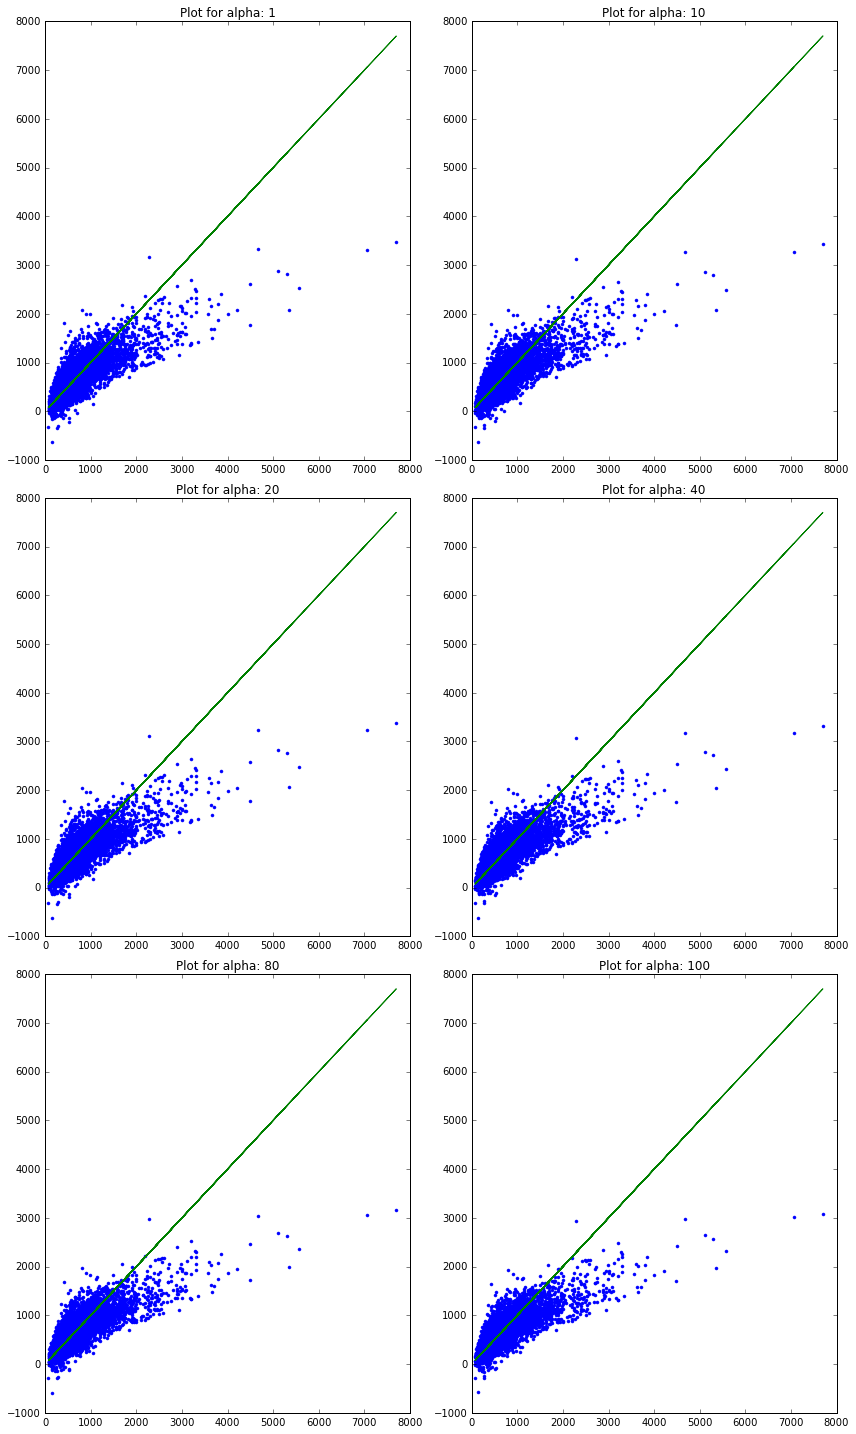

In [71]:
#Define the alpha values to test
alpha_lasso_sub_refine = [1, 10, 20, 40, 50, 60, 80, 100]

#Initialize the dataframe to store coefficients
col = ['rss','rmse','R2','intercept'] + sub_features
ind = ['alpha_%.2g'%alpha_lasso_sub_refine[i] for i in range(0,8)]
coef_matrix_lasso_sub_refine = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1:321, 10:322,20:323, 40:324, 80:325, 100:326}
#Iterate over the 8 alpha values:
for i in range(8):
    coef_matrix_lasso_sub_refine.iloc[i,] = lasso_regression(sub_feature_matrix,sub_output,
                                       test_sub_feature_matrix,test_sub_output,alpha_lasso_sub_refine[i], models_to_plot)

In [72]:
coef_matrix_lasso_sub_refine

,rss,rmse,R2,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,age
alpha_1,8.32499e+14,218835,0.627413,-1.05712e+06,-45890.8,48801.8,190.299,-0.197588,22932.5,731036,16395.4,132163,-14.3715,3887.31
alpha_10,8.33409e+14,218955,0.628069,-1.03812e+06,-42454.3,48141.3,178.18,-0.175287,14740.1,724784,15250.5,130797,-0,3803.79
alpha_20,8.3461e+14,219112,0.628457,-1.02142e+06,-38434.8,45066.1,176.049,-0.137064,10916.1,716058,13366,130454,-0,3687.33
alpha_40,8.3942e+14,219743,0.628014,-988133,-30370,38943.1,171.739,-0.0605754,3242.13,698630,9600.4,129778,0,3454.32
alpha_50,8.42965e+14,220206,0.627233,-972167,-26306.2,35739,169.617,-0.0218875,0,689901,7771.19,129387,0,3341.53
alpha_60,8.46648e+14,220687,0.626534,-959195,-22187.6,31682.4,168.004,-0,0,680976,6245.83,128632,0,3247.96
alpha_80,8.55317e+14,221814,0.624542,-931956,-14187.4,23339.1,165.465,-0,0,662895,3207.41,127029,0,3058.47
alpha_1e+02,8.66463e+14,223254,0.621245,-904772,-6180.89,15021.6,162.904,-0,0,644818,168.85,125429,0,2869.18


In [73]:
house_lasso_reg_model = Lasso(alpha=20,normalize=True, max_iter=1e5, fit_intercept=True)
house_lasso_reg_model.fit(sub_feature_matrix,sub_output)

Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)